Device: cpu

Imagen elegida al azar:
pruebas\ig2.jpg
Recorte guardado en temp_recortes/recorte.jpg (confianza 0.90)
Predicción: 83.31 / 100 (sin nota real en CSV)


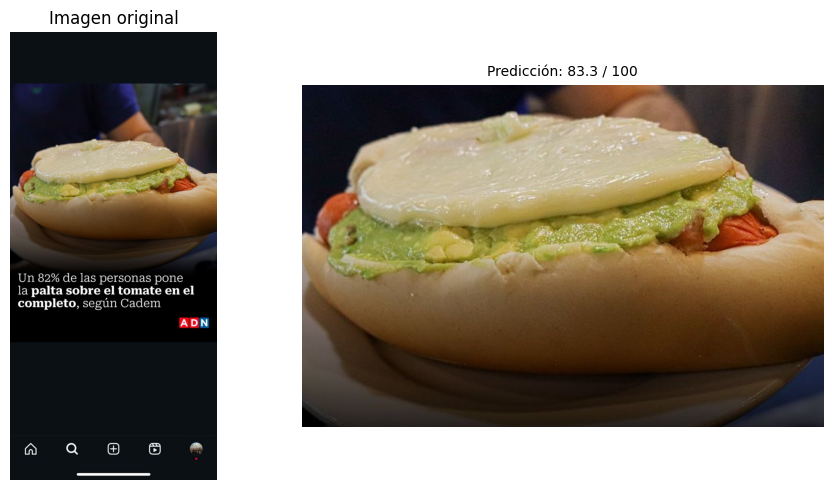

In [2]:
import os, random, cv2, math, torch, ast, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
import torch.nn as nn

BEST_PT = r"..\Detector completos\detector_completos\rf_completos\weights\best.pt" 
CROP_DIR = r"..\completos_regresion\v1 - Regresión simple\dataset\crops"
MERGED_CSV_PATH = r"..\completos_regresion\v1 - Regresión simple\dataset_regresion_extendido.csv"
IMG_SIZE = 224

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

detector = YOLO(BEST_PT)

weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
_mean, _std = weights.transforms().mean, weights.transforms().std
inference_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std),
])

model = mobilenet_v3_small(weights=weights)
in_f = model.classifier[3].in_features
model.classifier[3] = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)
model.load_state_dict(torch.load(r"..\completos_regresion\v1 - Regresión simple\checkpoints\best_model.pth", map_location=device))
model.eval()

merged = pd.read_csv(MERGED_CSV_PATH)
if "score_clean" not in merged.columns:
    def clean_score_cell(x):
        try:
            if isinstance(x, str):
                data = ast.literal_eval(x)
                if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                    return float(data[0]["number"])
                return float(x)
            return float(x)
        except Exception:
            return None
    merged["score_clean"] = merged["score"].apply(clean_score_cell)
merged["img_path_norm"] = merged["img_path"].astype(str).apply(lambda x: x.replace("\\", "/"))

def detectar_y_recortar(imagen_path, conf_minima=0.5, clase_objetivo=0):
    """
    Usa el detector YOLO para extraer el recorte del completo más confiable.
    Retorna el path del recorte guardado (recorte.jpg).
    """
    img = cv2.imread(imagen_path)
    resultados = detector.predict(imagen_path, conf=conf_minima, verbose=False)

    mejor_box = None
    mejor_conf = 0.0
    for r in resultados:
        for box in r.boxes:
            if int(box.cls[0]) == clase_objetivo and box.conf[0] >= conf_minima:
                conf = float(box.conf[0])
                if conf > mejor_conf:
                    mejor_conf = conf
                    mejor_box = box.xyxy[0]

    if mejor_box is None:
        raise ValueError("No se detectó ningún completo en la imagen.")

    x1, y1, x2, y2 = map(int, mejor_box)
    recorte = img[y1:y2, x1:x2]

    os.makedirs("temp_recortes", exist_ok=True)
    crop_path = "temp_recortes/recorte.jpg"
    cv2.imwrite(crop_path, recorte)

    print(f"Recorte guardado en {crop_path} (confianza {mejor_conf:.2f})")
    return crop_path

def predecir_y_mostrar_con_real(ruta_imagen_original, split="test"):
    """
    Detecta el crop con YOLO, predice nota con MobileNet y muestra ambas imágenes.
    """
    # Detectar y recortar
    crop_path = detectar_y_recortar(ruta_imagen_original, conf_minima=0.4)
    img_original = Image.open(ruta_imagen_original).convert("RGB")
    img_crop = Image.open(crop_path).convert("RGB")

    # Inferencia con el modelo de regresión
    img_t = inference_tfms(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t).cpu().numpy().flatten()[0] * 100.0

    ruta_norm = ruta_imagen_original.replace("\\", "/")
    match = merged[merged["img_path_norm"].str.endswith(os.path.basename(ruta_norm), na=False)]
    real = float(match.iloc[0]["score_clean"]) if len(match) > 0 else None

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_original)
    axes[0].axis("off")
    axes[0].set_title("Imagen original")

    axes[1].imshow(img_crop)
    axes[1].axis("off")
    if real is not None:
        delta = abs(pred - real)
        axes[1].set_title(f"Crop evaluado\nReal: {real:.1f} | Pred: {pred:.1f}\nΔ={delta:.1f}", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100  |  Real: {real:.2f}  |  Δ={delta:.2f}")
    else:
        axes[1].set_title(f"Predicción: {pred:.1f} / 100", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100 (sin nota real en CSV)")

    plt.tight_layout()
    plt.show()

    return pred, real, crop_path

#carpeta = r"..\Detector completos\Dataset-Comida-Chilena-1\test\images"
carpeta = r"pruebas"

imagenes = glob.glob(os.path.join(carpeta, "*.jpg"))
ruta_aleatoria = random.choice(imagenes)

print(f"\nImagen elegida al azar:\n{ruta_aleatoria}")
pred, real, crop_path = predecir_y_mostrar_con_real(ruta_aleatoria, split="test")


In [11]:
import numpy as np, cv2, hashlib, pandas as pd

def norm_to_xyxy_abs(det, W, H, fmt="xyxy_norm"):
    # det: [x1,y1,x2,y2,conf,cls] u [cx,cy,w,h,conf,cls] según fmt
    x1,y1,x2,y2,conf,cls = det
    if fmt == "xywh_norm":
        cx, cy, w, h = x1, y1, x2, y2
        x1 = (cx - w/2) * W;  y1 = (cy - h/2) * H
        x2 = (cx + w/2) * W;  y2 = (cy + h/2) * H
    elif fmt == "xyxy_norm":
        x1 *= W; y1 *= H; x2 *= W; y2 *= H
    # si ya viene en píxeles usa fmt="xyxy_abs" y no escales
    x1, y1 = int(max(0, x1)), int(max(0, y1))
    x2, y2 = int(min(W-1, x2)), int(min(H-1, y2))
    return x1,y1,x2,y2,float(conf),int(cls)

def detections_df(detections, W, H, fmt, clase_objetivo=None, conf_min=0.3):
    rows = []
    for det in detections:
        x1,y1,x2,y2,conf,cls = norm_to_xyxy_abs(det, W, H, fmt=fmt)
        if conf < conf_min: continue
        if clase_objetivo is not None and cls != clase_objetivo: continue
        area = max(0,(x2-x1)) * max(0,(y2-y1))
        rows.append(dict(x1=x1,y1=y1,x2=x2,y2=y2,conf=conf,cls=cls,area=area))
    df = pd.DataFrame(rows)
    if not df.empty:
        df["score_sel"] = df["conf"]  # o df["conf"] * np.sqrt(df["area"]) si quieres
        df = df.sort_values(["score_sel","conf","area"], ascending=False).reset_index(drop=True)
        df["rank"] = np.arange(1, len(df)+1)
    return df

def crop_and_md5(img_bgr, box):
    x1,y1,x2,y2 = box
    crop = img_bgr[y1:y2, x1:x2]
    ok, buf = cv2.imencode(".png", crop)   # siempre BGR->PNG
    md5 = hashlib.md5(buf).hexdigest() if ok else "ERR"
    return crop, md5


Device: cuda


C:\Users\anays\AppData\Local\Temp\ipykernel_18672\1460475434.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(BEST_MODEL_PATH, map_location=device)


Modelo EfficientNet-Lite0 cargado correctamente.

Imagen elegida al azar:
pruebas\ig2.jpg
Recorte guardado en temp_recortes/recorte.jpg (confianza 0.87)
Predicción: 66.23 / 100  |  Real: 90.00  |  Δ=23.77


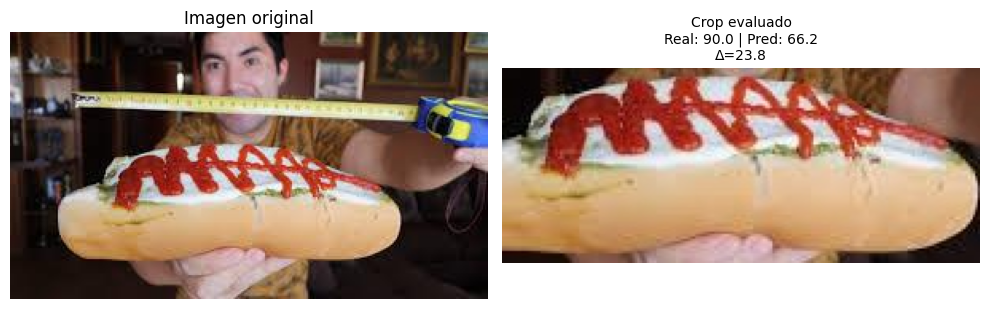

In [20]:
# =========================================================
# INFERENCIA COMPLETA CON EfficientNet-Lite0 + YOLO
# =========================================================
import os, random, cv2, math, torch, ast, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from torchvision import transforms
import timm
import torch.nn as nn
from pathlib import Path

# ---------------------------------------------------------
# CONFIGURACIONES GENERALES
# ---------------------------------------------------------
BEST_PT = r"..\Detector completos\detector_completos\rf_completos\weights\best.pt"
MERGED_CSV_PATH = r"..\completos_regresion\v1 - Regresión simple\dataset_regresion_extendido.csv"
BEST_MODEL_PATH = r"..\completos_regresion\v1 - Regresión simple\runs\effnet_lite0_regresion\best_model.pth"
IMG_SIZE = 240

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------------------------
# CARGAR DETECTOR YOLO
# ---------------------------------------------------------
detector = YOLO(BEST_PT)

# ---------------------------------------------------------
# TRANSFORMS para EfficientNet-Lite0
# ---------------------------------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
inference_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ---------------------------------------------------------
# CARGAR MODELO EfficientNet-Lite0
# ---------------------------------------------------------
model = timm.create_model("efficientnet_lite0", pretrained=False)
in_f = model.classifier.in_features
model.classifier = nn.Sequential(nn.Linear(in_f, 1), nn.Sigmoid())
model = model.to(device)

state = torch.load(BEST_MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Modelo EfficientNet-Lite0 cargado correctamente.")

# ---------------------------------------------------------
# CARGAR CSV CON NOTAS (para obtener valores reales)
# ---------------------------------------------------------
merged = pd.read_csv(MERGED_CSV_PATH)

if "score_clean" not in merged.columns:
    def clean_score_cell(x):
        try:
            if isinstance(x, str):
                data = ast.literal_eval(x)
                if isinstance(data, list) and data and isinstance(data[0], dict) and "number" in data[0]:
                    return float(data[0]["number"])
                return float(x)
            return float(x)
        except Exception:
            return None
    merged["score_clean"] = merged["score"].apply(clean_score_cell)

merged["img_path_norm"] = merged["img_path"].astype(str).apply(lambda x: x.replace("\\", "/"))

# ---------------------------------------------------------
# FUNCIÓN: DETECTAR Y RECORTAR CON YOLO
# ---------------------------------------------------------
def detectar_y_recortar(imagen_path, conf_minima=0.5, clase_objetivo=0):
    """
    Usa YOLO para extraer el recorte del completo más confiable.
    Retorna el path del recorte guardado (recorte.jpg).
    """
    img = cv2.imread(imagen_path)
    resultados = detector.predict(imagen_path, conf=conf_minima, verbose=False)
    mejor_box, mejor_conf = None, 0.0

    for r in resultados:
        for box in r.boxes:
            if int(box.cls[0]) == clase_objetivo and box.conf[0] >= conf_minima:
                conf = float(box.conf[0])
                if conf > mejor_conf:
                    mejor_conf = conf
                    mejor_box = box.xyxy[0]

    if mejor_box is None:
        raise ValueError("No se detectó ningún completo en la imagen.")

    x1, y1, x2, y2 = map(int, mejor_box)
    recorte = img[y1:y2, x1:x2]

    os.makedirs("temp_recortes", exist_ok=True)
    crop_path = "temp_recortes/recorte.jpg"
    cv2.imwrite(crop_path, recorte)

    print(f"Recorte guardado en {crop_path} (confianza {mejor_conf:.2f})")
    return crop_path,resultados

# ---------------------------------------------------------
# FUNCIÓN: PREDICCIÓN + VISUALIZACIÓN
# ---------------------------------------------------------
def predecir_y_mostrar_con_real(ruta_imagen_original):
    """
    Detecta el crop con YOLO, predice nota con EfficientNet-Lite0 y muestra resultados.
    """
    crop_path,resultados = detectar_y_recortar(ruta_imagen_original, conf_minima=0.4)
    img_original = Image.open(ruta_imagen_original).convert("RGB")
    img_crop = Image.open(crop_path).convert("RGB")

    # 🔹 Inferencia
    img_t = inference_tfms(img_crop).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t).cpu().numpy().flatten()[0] * 100.0

    # 🔹 Buscar nota real (si está en el CSV)
    ruta_norm = ruta_imagen_original.replace("\\", "/")
    match = merged[merged["img_path_norm"].str.endswith(os.path.basename(ruta_norm), na=False)]
    real = float(match.iloc[0]["score_clean"]) if len(match) > 0 else None

    # 🔹 Mostrar comparación
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_original)
    axes[0].axis("off")
    axes[0].set_title("Imagen original")

    axes[1].imshow(img_crop)
    axes[1].axis("off")
    if real is not None:
        delta = abs(pred - real)
        axes[1].set_title(f"Crop evaluado\nReal: {real:.1f} | Pred: {pred:.1f}\nΔ={delta:.1f}", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100  |  Real: {real:.2f}  |  Δ={delta:.2f}")
    else:
        axes[1].set_title(f"Predicción: {pred:.1f} / 100", fontsize=10)
        print(f"Predicción: {pred:.2f} / 100 (sin nota real en CSV)")

    plt.tight_layout()
    plt.show()

    return pred, real, crop_path, resultados

# ---------------------------------------------------------
# EJEMPLO DE USO (imagen aleatoria o carpeta "pruebas")
# ---------------------------------------------------------
carpeta = r"pruebas"  # cambia si quieres usar otra carpeta
imagenes = glob.glob(os.path.join(carpeta, "*.jpg"))
if not imagenes:
    raise FileNotFoundError(f"No se encontraron imágenes en {carpeta}")

ruta_aleatoria = random.choice(imagenes)
print(f"\nImagen elegida al azar:\n{ruta_aleatoria}")
pred, real, crop_path,resultados = predecir_y_mostrar_con_real(r"C:\Users\anays\OneDrive\Escritorio\SHEFU - ENTREGABLE VC\Completos\Detector completos\Dataset-Comida-Chilena-1\test\images\images-2023-05-30T190049-098_jpg.rf.f9545cf1fc35788bd5bc3d92053198b0.jpg")


Modelos cargados correctamente.
Detector input: [  1 320 320   3]  → output: [  1 300   6]
Regresor input: [  1   3 240 240]  → output: [1 1]
Input real enviado al YOLO: (1, 320, 320, 3)

Primeras detecciones (x1,y1,x2,y2,conf,cls):
[    0.12038     0.40081     0.81458      0.8906      0.9073           0]
[   0.018506 -0.00011047     0.15556      0.0468           0           0]
[    0.37042 -2.9507e-05     0.60846    0.077828           0           0]
[    0.21858 -0.00016988     0.40466    0.087195           0           0]
[     0.8699   0.0077919     0.94427     0.11424           0           0]

Detecciones válidas: 1
00) conf=0.91, box=(36,67,244,149)
YOLO inference: 55.7 ms
Salida detecciones: (300, 6)

Total bruto de detecciones: 300
Rango x,y,w,h → min=-0.000, max=1.009

Detecciones válidas (conf>0.3):
 01) conf=0.91 box=(36,67,244,149) size=(208x82)

Detección elegida (mayor confianza): conf=0.91 box=(36,67,244,149)


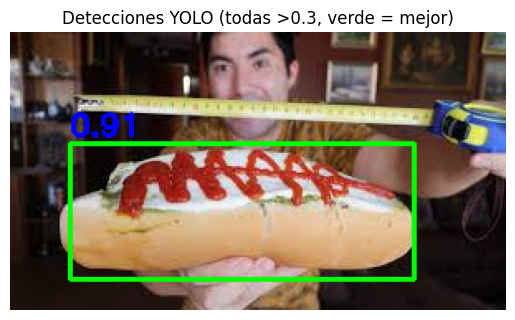

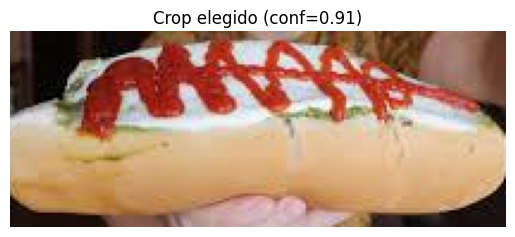

Input EfficientNet: (1, 3, 240, 240)
Esperado por el modelo: [  1   3 240 240]
EfficientNet inference: 19.2 ms
Predicción final: 68.81 / 100


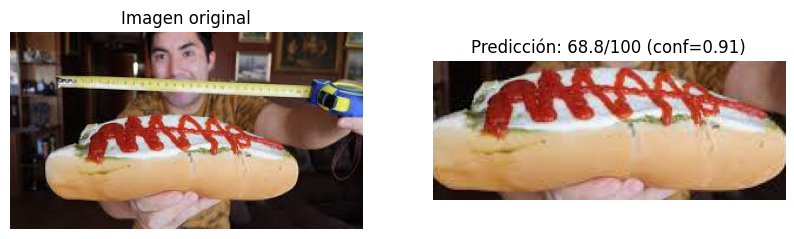

In [25]:
# =========================================================
# SIMULACIÓN DE FLUJO FLUTTER
# YOLO (detección) + EfficientNet-Lite0 (regresión)
# =========================================================
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os, random, time

# ---------------------------------------------------------
# Rutas de los modelos TFLite
# ---------------------------------------------------------
YOLO_TFLITE = r"..\Detector completos\detector_completos\rf_completos\weights\best_saved_model\best_float32.tflite"
REG_TFLITE  = r"efficientnet_lite0.tflite"

# Imagen de prueba
IMAGEN = random.choice([
    r"C:\Users\anays\OneDrive\Escritorio\SHEFU - ENTREGABLE VC\Completos\Detector completos\Dataset-Comida-Chilena-1\test\images\images-2023-05-30T190049-098_jpg.rf.f9545cf1fc35788bd5bc3d92053198b0.jpg",
])

# ---------------------------------------------------------
# Cargar intérpretes TFLite
# ---------------------------------------------------------
detector_interpreter = tf.lite.Interpreter(model_path=YOLO_TFLITE)
regresor_interpreter = tf.lite.Interpreter(model_path=REG_TFLITE)

detector_interpreter.allocate_tensors()
regresor_interpreter.allocate_tensors()

# ---------------------------------------------------------
# Obtener detalles de entrada/salida
# ---------------------------------------------------------
det_input = detector_interpreter.get_input_details()[0]
det_output = detector_interpreter.get_output_details()[0]
reg_input = regresor_interpreter.get_input_details()[0]
reg_output = regresor_interpreter.get_output_details()[0]

print("Modelos cargados correctamente.")
print(f"Detector input: {det_input['shape']}  → output: {det_output['shape']}")
print(f"Regresor input: {reg_input['shape']}  → output: {reg_output['shape']}")

# ---------------------------------------------------------
# Preprocesamiento YOLO
# ---------------------------------------------------------
orig = cv2.imread(IMAGEN)
img = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (320, 320))

# Determinar formato correcto (NHWC o NCHW)
input_shape = det_input["shape"]
if input_shape[1] == 320 and input_shape[2] == 320:
    # NHWC
    input_data = np.expand_dims(img_resized / 255.0, axis=0).astype(np.float32)
else:
    # NCHW
    input_data = img_resized.astype(np.float32) / 255.0
    input_data = np.transpose(input_data, (2, 0, 1))  # HWC -> CHW
    input_data = np.expand_dims(input_data, axis=0)

print("Input real enviado al YOLO:", input_data.shape)

# ---------------------------------------------------------
# Inferencia YOLO
# ---------------------------------------------------------
detector_interpreter.set_tensor(det_input['index'], input_data)
t0 = time.time()
detector_interpreter.invoke()

# Obtener detalles de salida
output_details = detector_interpreter.get_output_details()
output_index = output_details[0]['index']

output_data = detector_interpreter.get_tensor(output_index)[0]

print("\nPrimeras detecciones (x1,y1,x2,y2,conf,cls):")
for det in output_data[:5]:
    print(det)

# Escalar coordenadas a tamaño original (por ejemplo, 1440x1080)
H, W = orig.shape[:2]
detections = []
for (x1, y1, x2, y2, conf, cls) in output_data:
    if conf < 0.1:
        continue
    x1, y1, x2, y2 = int(x1 * W), int(y1 * H), int(x2 * W), int(y2 * H)
    detections.append((x1, y1, x2, y2, conf, int(cls)))

print(f"\nDetecciones válidas: {len(detections)}")
for i, (x1,y1,x2,y2,conf,cls) in enumerate(detections):
    print(f"{i:02d}) conf={conf:.2f}, box=({x1},{y1},{x2},{y2})")

t1 = time.time()

detections = detector_interpreter.get_tensor(det_output['index'])[0]  # (N,6)
print(f"YOLO inference: {(t1 - t0)*1000:.1f} ms")
print(f"Salida detecciones: {detections.shape}")

# ---------------------------------------------------------
# Procesamiento de detecciones (normalizadas a [0,1])
# ---------------------------------------------------------
H, W, _ = orig.shape
boxes = []

print(f"\nTotal bruto de detecciones: {len(detections)}")
print(f"Rango x,y,w,h → min={detections[:, :4].min():.3f}, max={detections[:, :4].max():.3f}")

# Recorre y escala coordenadas normalizadas
for det in detections:
    x1, y1, x2, y2, conf, cls = det
    if conf < 0.3:
        continue

    # Escalar coordenadas normalizadas [0,1] al tamaño original
    x1 = int(x1 * W)
    y1 = int(y1 * H)
    x2 = int(x2 * W)
    y2 = int(y2 * H)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(W - 1, x2), min(H - 1, y2)

    if x2 > x1 and y2 > y1:
        boxes.append((x1, y1, x2, y2, float(conf)))

if not boxes:
    raise ValueError("No se detectó ningún completo válido (confianza < 0.3).")

# ---------------------------------------------------------
# Seleccionar la detección con mayor confianza
# ---------------------------------------------------------
confidences = [b[4] for b in boxes]
best_idx = int(np.argmax(confidences))
x1, y1, x2, y2, conf = boxes[best_idx]

print("\nDetecciones válidas (conf>0.3):")
for i, b in enumerate(boxes):
    print(f" {i+1:02d}) conf={b[4]:.2f} box=({b[0]},{b[1]},{b[2]},{b[3]}) size=({b[2]-b[0]}x{b[3]-b[1]})")

print(f"\nDetección elegida (mayor confianza): conf={conf:.2f} box=({x1},{y1},{x2},{y2})")

# ---------------------------------------------------------
# Visualizar todas las detecciones
# ---------------------------------------------------------
img_show = orig.copy()
for (bx1, by1, bx2, by2, c) in boxes:
    color = (0, 255, 0) if c == conf else (255, 255, 0)
    cv2.rectangle(img_show, (bx1, by1), (bx2, by2), color, 2)
    cv2.putText(img_show, f"{c:.2f}", (bx1, max(0, by1 - 5)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title("Detecciones YOLO (todas >0.3, verde = mejor)")
plt.axis("off")
plt.show()

# ---------------------------------------------------------
# Recortar la detección principal
# ---------------------------------------------------------
crop = orig[y1:y2, x1:x2]
if crop.size == 0:
    raise ValueError(f"Recorte vacío con box=({x1},{y1},{x2},{y2}).")

plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.title(f"Crop elegido (conf={conf:.2f})")
plt.axis("off")
plt.show()



# ---------------------------------------------------------
# Preprocesamiento EfficientNet-Lite0
# ---------------------------------------------------------
IMG_SIZE = reg_input["shape"][2]  # 240
img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
img_reg = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
img_reg = img_reg.astype(np.float32) / 255.0
img_reg = (img_reg - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
img_reg = np.transpose(img_reg, (2, 0, 1))   # (3,240,240)
input_reg = np.expand_dims(img_reg, axis=0).astype(np.float32)

print("Input EfficientNet:", input_reg.shape)
print("Esperado por el modelo:", reg_input["shape"])

# ---------------------------------------------------------
# Inferencia EfficientNet
# ---------------------------------------------------------
regresor_interpreter.set_tensor(reg_input['index'], input_reg)
t2 = time.time()
regresor_interpreter.invoke()
t3 = time.time()

pred = regresor_interpreter.get_tensor(reg_output['index']).flatten()[0]
pred_score = float(pred * 100.0)
print(f"EfficientNet inference: {(t3-t2)*1000:.1f} ms")
print(f"Predicción final: {pred_score:.2f} / 100")

# ---------------------------------------------------------
# Visualización final
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
plt.title(f"Predicción: {pred_score:.1f}/100 (conf={conf:.2f})")
plt.axis("off")
plt.show()


In [ ]:
orig = cv2.imread(r"pruebas\ig1.jpg")         # BGR
H, W = orig.shape[:2]

# A) YOLO de ultralytics -> lista de (xyxy_abs, conf, cls)
# convier­te sus boxes a una lista con mismo formato de columnas que `detections`
dets_A = []
for r in resultados:  # normalmente 1 imagen = 1 r
    for b in r.boxes:
        x1,y1,x2,y2 = map(float, b.xyxy[0].tolist())
        conf = float(b.conf[0]); cls = int(b.cls[0])
        dets_A.append([x1,y1,x2,y2,conf,cls])
dfA = detections_df(dets_A, W, H, fmt="xyxy_abs", clase_objetivo=0, conf_min=0.3)

# B)  tensor `detections` (normalizado)
dfB = detections_df(detections, W, H, fmt="xyxy_norm", clase_objetivo=0, conf_min=0.3)

print("\n=== A: YOLO ultralytics (abs) ==="); print(dfA)
print("\n=== B: Tensor/otra ruta (norm) ==="); print(dfB)

boxA = (dfA.loc[0, ["x1","y1","x2","y2"]].astype(int).tolist()) if not dfA.empty else None
boxB = (dfB.loc[0, ["x1","y1","x2","y2"]].astype(int).tolist()) if not dfB.empty else None

cropA, md5A = crop_and_md5(orig, boxA) if boxA else (None, None)
cropB, md5B = crop_and_md5(orig, boxB) if boxB else (None, None)

print(f"\nMD5 A={md5A}  |  MD5 B={md5B}  |  iguales? {md5A==md5B}")



=== A: YOLO ultralytics (abs) ===
    x1   y1   x2    y2      conf  cls    area  score_sel  rank
0  172  686  427  1285  0.773621    0  152745   0.773621     1

=== B: Tensor/otra ruta (norm) ===
    x1    y1   x2    y2      conf  cls    area  score_sel  rank
0  579  1016  738  1440  0.852040    0   67416   0.852040     1
1  154   789  417  1259  0.390706    0  123610   0.390706     2

MD5 A=ae298842d908c7c8669ac730f969d371  |  MD5 B=f03eba4d1a3ef3222a630380583e3c2f  |  iguales? False
